In [1]:
import os
import json
import numpy as np


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb

In [3]:
from utils import read_features, read_targets, print_info_features, metrics_c, evaluate, plot_confusion_matrix, plot_cm_pies, scale_all, reduce_all, add_all_feature_combos, encode_labels, load_best_params, plot_prediction_scores

## Read Features and Targets


In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [5]:
X = read_features(path)
y = read_targets(path, ["HistoricalPeriod"])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Extra Preprocessing

### Scale Features

In [6]:
X = scale_all(X)

### Reduce Features

Use n_components=0.95 to keep enough components to preserve 95% of the variance in the data.

In [7]:
X_reduced = reduce_all(X, n_components=0.95)

### Combine & Re-scale Text & Image Feature Sets

In [8]:
X = add_all_feature_combos(X, scale=True)

X_reduced = add_all_feature_combos(X_reduced, scale=True)

### Final Feature Sets

In [9]:
print_info_features(X)

{
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		tfidf + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 3217), 
		tfidf + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2348), 
		tfidf + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 1068), 
		bert + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 3685), 
		bert + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2816), 
		bert + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 1536), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert

In [10]:
print_info_features(X_reduced)

{
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 225), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 190), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 262), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 177), 
		tfidf + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 490), 
		tfidf + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 562), 
		tfidf + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 477), 
		bert + cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 415), 
		bert + resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 487), 
		bert + vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 402), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert: 
			<c

### Encode Target Labels

In [11]:
y, target_enc, le = encode_labels(y, "HistoricalPeriod")

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


## Load Best Parameters from HP Tuning

In [12]:
path_params = "best_params.json"
best_params = load_best_params(path_params)

## Fit Best Model-Feature Pairs & Predict Test Set

### Predict *HistoricalPeriod* with *Text Data*

Best Model and Text Feature Set Pair Based on Cross Validation:
- Classification Model: **XGBoost**
- Text Feature Set: **TF-IDF**

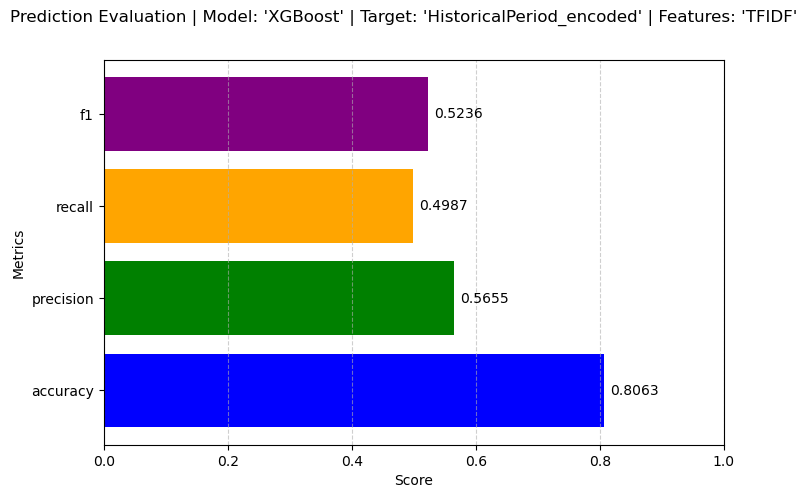

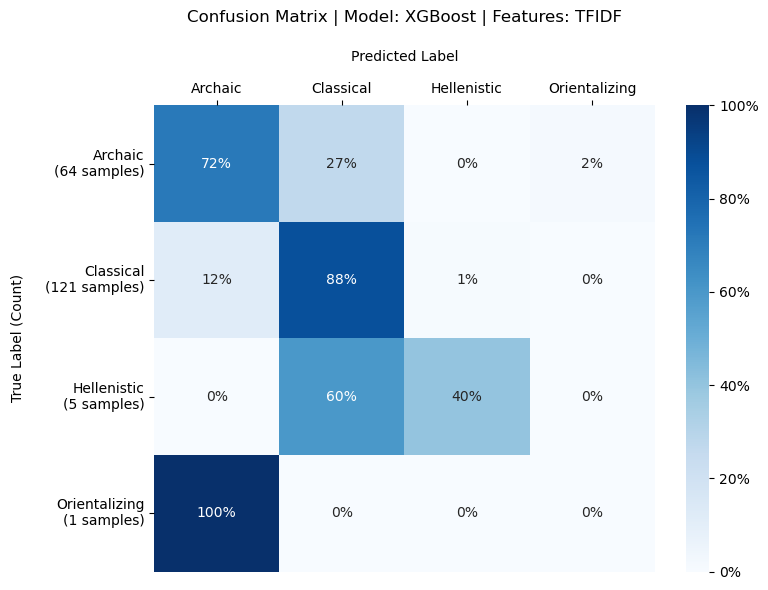

In [13]:
model_class = XGBClassifier
model_name = 'XGBoost'
features = "tfidf"
params = best_params[model_name][(features, target_enc)]["params"]

# Initialize Model
model = model_class(**params)

# Fit
model.fit(X_reduced["train"][features].to_numpy(), y["train"][target_enc].to_numpy())

# Predict
y_pred = model.predict(X_reduced["test"][features].to_numpy())

# Evaluate
scores = evaluate(y["test"][target_enc], y_pred, metrics_c)
plot_prediction_scores(scores, model_name, target_enc, features)

# Confusion Matrix
cm = confusion_matrix(y["test"][target_enc], y_pred)
plot_confusion_matrix(cm, le, model_name, features)

### Predict *HistoricalPeriod* with *Image Data*

Best Model and Image Feature Set Pair Based on Cross Validation:
- Classification Model: **Logistic Regression**
- Image Feature Set: **VIT**

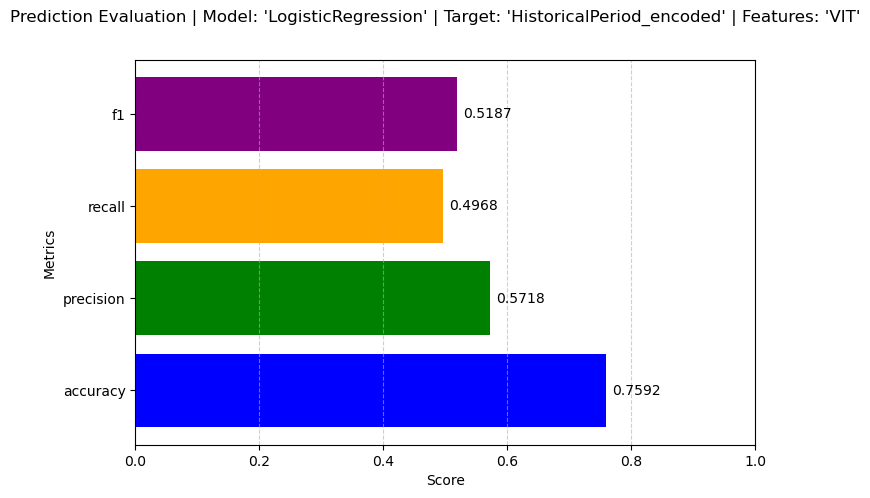

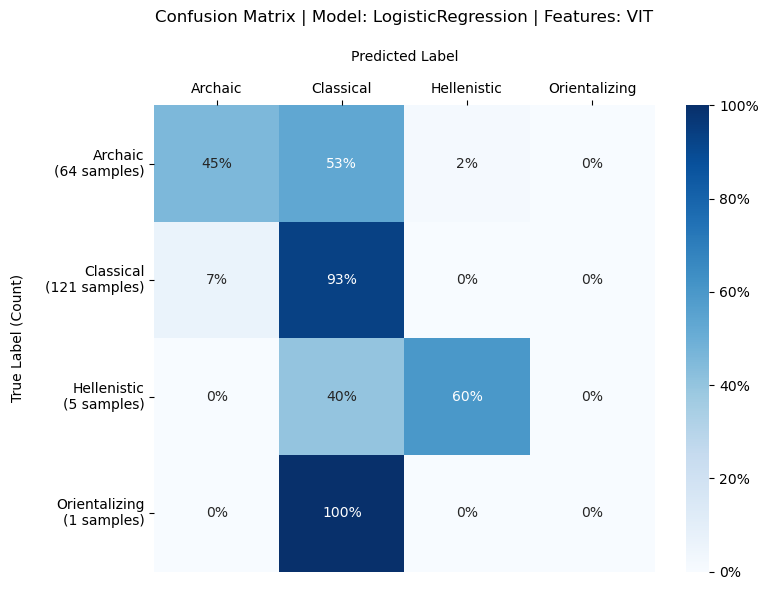

In [14]:
model_class = LogisticRegression
model_name = 'LogisticRegression'
features = "vit"
params = best_params[model_name][(features, target_enc)]["params"]

# Initialize Model
model = model_class(**params)

# Fit
model.fit(X["train"][features], y["train"][target_enc])

# Predict
y_pred = model.predict(X["test"][features])

# Evaluate
scores = evaluate(y["test"][target_enc], y_pred, metrics_c)
plot_prediction_scores(scores, model_name, target_enc, features)

# Confusion Matrix
cm = confusion_matrix(y["test"][target_enc], y_pred)
plot_confusion_matrix(cm, le, model_name, features)

### Predict *HistoricalPeriod* with *Text & Image Combination Data*

Best Model and Combo Feature Set Pair Based on Cross Validation:
- Classification Model: **Logistic Regression**
- Combo Feature Set: **TF-IDF + VIT**

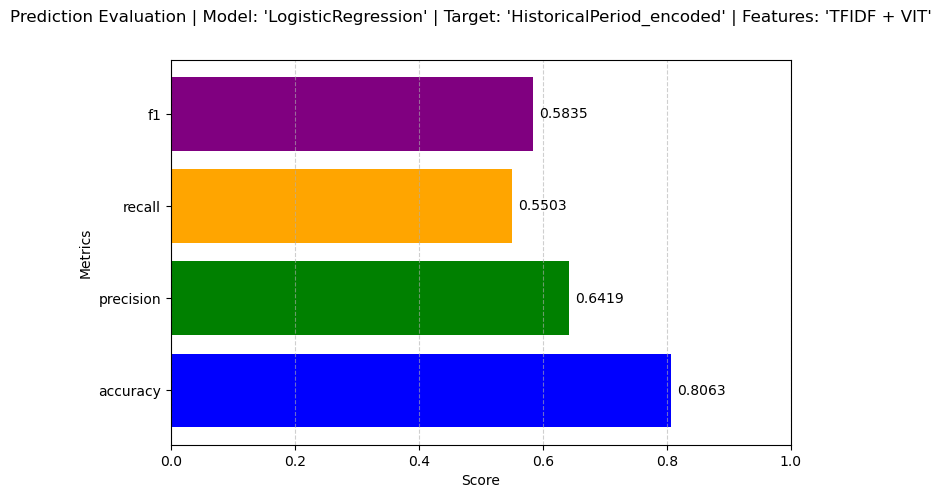

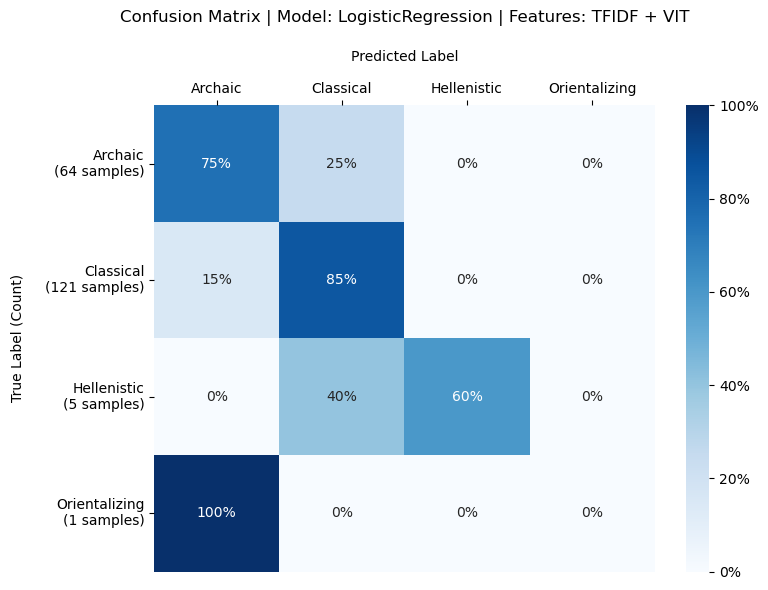

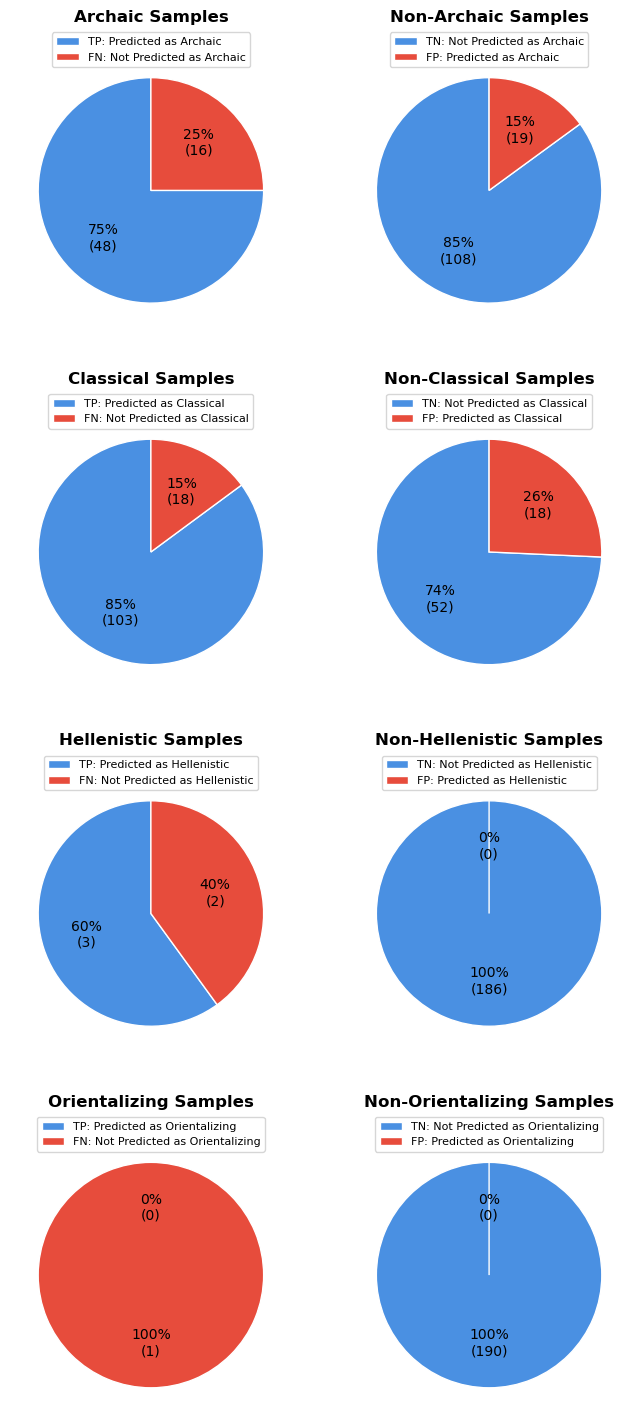

In [15]:
model_class = LogisticRegression
model_name = 'LogisticRegression'
features = "tfidf + vit"
params = best_params[model_name][(features, target_enc)]["params"]

# Initialize Model
model = model_class(**params)

# Fit
model.fit(X["train"][features], y["train"][target_enc])

# Predict
y_pred = model.predict(X["test"][features])

# Evaluate
scores = evaluate(y["test"][target_enc], y_pred, metrics_c)
plot_prediction_scores(scores, model_name, target_enc, features)

# Confusion Matrix
cm = confusion_matrix(y["test"][target_enc], y_pred)
plot_confusion_matrix(cm, le, model_name, features)
plot_cm_pies(cm, le)